In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.callbacks import ReduceLROnPlateau
from keras.layers.convolutional import MaxPooling2D, Conv2D, SeparableConv2D
from keras.layers import Activation, Flatten, Concatenate, GlobalAveragePooling2D, Input, Lambda, Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers.advanced_activations import ReLU, Softmax
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import keras

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


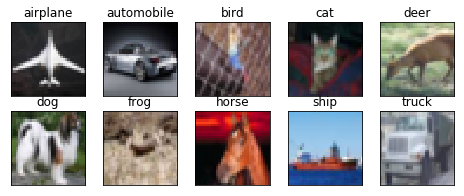

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_bs2(x):
  return tf.space_to_depth(x, block_size=2)

def space_to_depth_bs4(x):
  return tf.space_to_depth(x, block_size=4)

In [0]:
from keras.layers import Activation


# Input
x1 = Input(shape = (32,32,3))



# First Block
# Separable Convolution
x2 = SeparableConv2D(16, (5,5), padding = 'same', name = 'SepConv1', kernel_regularizer = regularizers.l2(0.01))(x1)#32
x2 = ReLU()(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)


# Normal Convolution
x3 = Conv2D(32, (5,5), padding = 'same', name = 'Conv2', kernel_regularizer = regularizers.l2(0.01))(x2)#32
x3 = ReLU()(x3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.5)(x3)

# Normal Convolution
x4 = Conv2D(32, (5,5), padding = 'same', name = 'Conv3', kernel_regularizer = regularizers.l2(0.01))(x3)#32
x4 = ReLU()(x4)
x4 = BatchNormalization()(x4)
x4 = Dropout(0.5)(x4)

x4_1 = Concatenate(axis = -1)([x4, x2])

# Separable Convolution
x5 = SeparableConv2D(32, (5,5), padding = 'same', name = 'SepConv4', kernel_regularizer = regularizers.l2(0.01))(x4_1)#32
x5 = ReLU()(x5)
x5 = BatchNormalization()(x5)
x5 = Dropout(0.5)(x5)

x2_s2d_b1 = Lambda(space_to_depth_bs2)(x2)
x3_s2d_b1 = Lambda(space_to_depth_bs2)(x3)
x4_s2d_b1 = Lambda(space_to_depth_bs2)(x4)
x5_s2d_b1 = Lambda(space_to_depth_bs2)(x5)


# Maxpooling Layer
x5 = Conv2D(16, (1,1), padding = 'same', name = 'x1Conv')(x5)#32
x5_1 = Concatenate(axis = -1)([x2, x5])
x6 =  MaxPooling2D(pool_size=(2, 2))(x5_1) #16



# Second Block
# Separable Convolution
x7 = SeparableConv2D(16, (3,3), padding = 'same', name = 'SepConv5', kernel_regularizer = regularizers.l2(0.01))(x6)#16
x7 = ReLU()(x7)
x7 = BatchNormalization()(x7)
x7 = Dropout(0.5)(x7)

x7_1 = Concatenate(axis = -1)([x2_s2d_b1, x5_s2d_b1, x7])

# Normal Convolution
x8 = Conv2D(32, (5,5), padding = 'same', name = 'Conv6', kernel_regularizer = regularizers.l2(0.01))(x7_1)#16
x8 = ReLU()(x8)
x8 = BatchNormalization()(x8)
x8 = Dropout(0.5)(x8)

x8_1 = Concatenate(axis = -1)([x8, x4_s2d_b1, x5_s2d_b1, x7])

# Separable Convolution
x9 = SeparableConv2D(32, (3,3), padding = 'same',  name = 'SepConv7', kernel_regularizer = regularizers.l2(0.01))(x8_1)#16
x9 = ReLU()(x9)
x9 = BatchNormalization()(x9)
x9 = Dropout(0.5)(x9)

x9_1 = Concatenate(axis = -1)([x2_s2d_b1, x4_s2d_b1, x5_s2d_b1, x7, x8, x9])

# Separable Convolution
x10 = SeparableConv2D(32, (5,5), padding = 'same',  name = 'SepConv8', kernel_regularizer = regularizers.l2(0.01))(x9_1)
x10 = ReLU()(x10)
x10 = BatchNormalization()(x10)
x10 = Dropout(0.5)(x10)


# Maxpooling Layer
x10 = Conv2D(16, (1,1), padding = 'same', name = 'x2Conv')(x10)
x10_1 = Concatenate(axis = -1)([x2_s2d_b1, x5_s2d_b1, x7, x9, x10])
x11 = MaxPooling2D(pool_size = (2, 2))(x10_1)#8


x2_s4d_b2 = Lambda(space_to_depth_bs4)(x2)
x3_s4d_b2 = Lambda(space_to_depth_bs4)(x3)
x4_s4d_b2 = Lambda(space_to_depth_bs4)(x4)
x5_s4d_b2 = Lambda(space_to_depth_bs4)(x5)

x7_s2d_b2 = Lambda(space_to_depth_bs2)(x7)
x8_s2d_b2 = Lambda(space_to_depth_bs2)(x8)
x9_s2d_b2 = Lambda(space_to_depth_bs2)(x9)
x10_s2d_b2 = Lambda(space_to_depth_bs2)(x10)



# Third Block
x11_1 = Concatenate(axis = -1)([x8_s2d_b2, x11])

# Normal Convolution
x12 = Conv2D(16, (5,5), padding = 'same', name = 'Conv9', kernel_regularizer = regularizers.l2(0.02))(x11_1)#8
x12 = ReLU()(x12)
x12 = BatchNormalization()(x12)
x12 = Dropout(0.5)(x12)

x12_1 = Concatenate(axis = -1)([x3_s4d_b2, x5_s4d_b2, x9_s2d_b2, x12])

# Separable Convolution
x13 = SeparableConv2D(16, (5,5), padding = 'same',  name = 'SepConv10', kernel_regularizer = regularizers.l2(0.01))(x12_1)
x13 = ReLU()(x13)
x13 = BatchNormalization()(x13)
x13 = Dropout(0.5)(x13)

x13_1 = Concatenate(axis = -1)([x3_s4d_b2, x4_s4d_b2, x7_s2d_b2, x12, x13])

# Normal Convolution
x14 = Conv2D(32, (5,5), padding = 'same', name = 'Conv11', kernel_regularizer = regularizers.l2(0.01))(x13_1)#8
x14 = ReLU()(x14)
x14 = BatchNormalization()(x14)
x14 = Dropout(0.5)(x14)

x14_1 = Concatenate(axis = -1)([x2_s4d_b2, x4_s4d_b2, x5_s4d_b2, x7_s2d_b2, x9_s2d_b2, x13, x14])

# Separable Convolution
x15 = SeparableConv2D(64, (5,5), padding = 'same',  name = 'SepConv12', kernel_regularizer = regularizers.l2(0.02))(x14_1)#8
x15 = ReLU()(x15)

x15_1 = Concatenate(axis = -1)([x5_s4d_b2, x9_s2d_b2, x13, x15])


# Softmax Layer
x16 = Conv2D(10, (1,1), name = 'x3Conv',)(x15_1)#8
flat_layer = GlobalAveragePooling2D()(x16)
output = Activation('softmax')(flat_layer)


model = Model(x1, output)
model.summary()

W0619 19:39:01.995529 139648843204480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 19:39:02.034821 139648843204480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 19:39:02.044734 139648843204480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 19:39:02.098008 139648843204480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0619 19:39:02.099398 1396488432

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
SepConv1 (SeparableConv2D)      (None, 32, 32, 16)   139         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 32, 32, 16)   0           SepConv1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          re_lu_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 

# Visualizing the Network Architecture

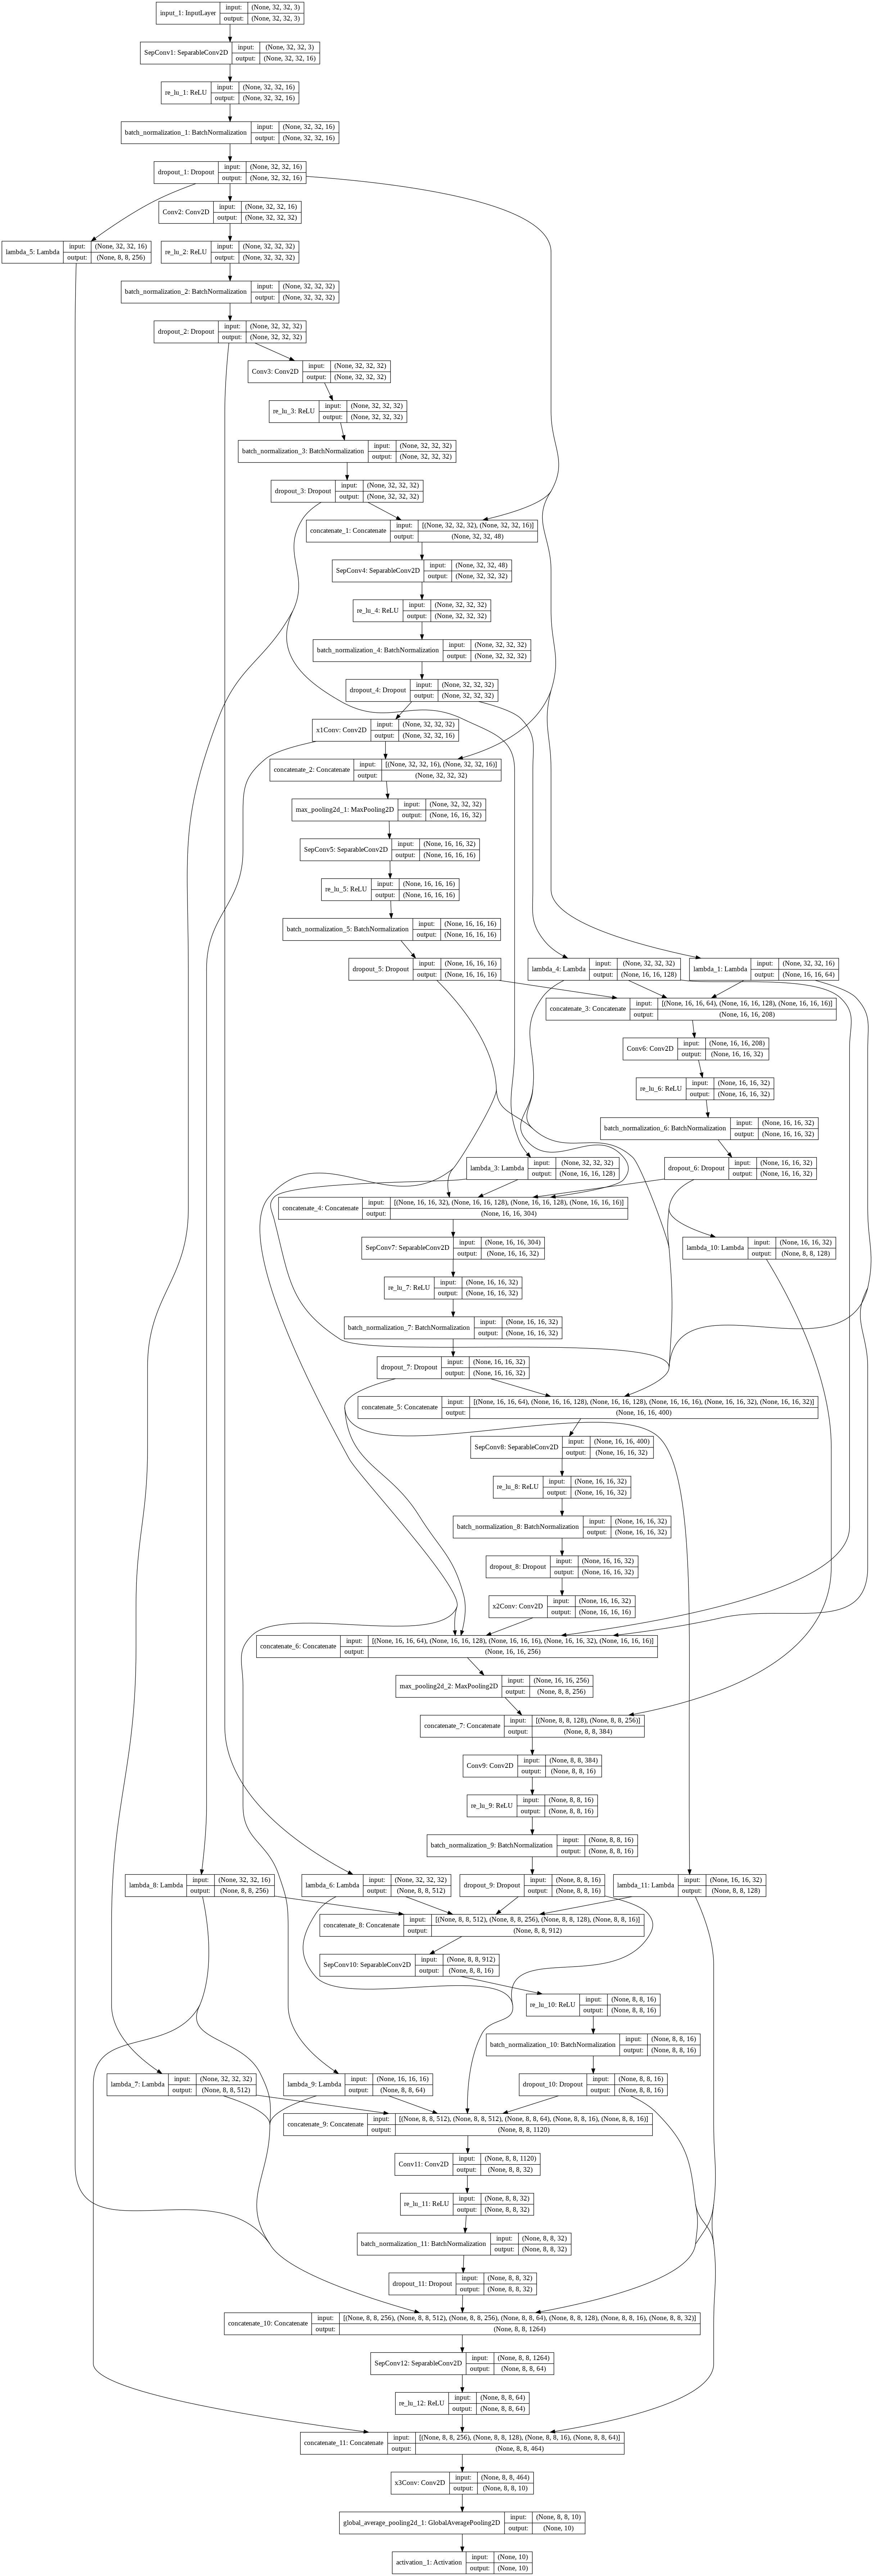

In [0]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='ENAS_CIFAR10_7B_Network.png')

from IPython.display import Image
Image(retina=True, filename='ENAS_CIFAR10_7B_Network.png')

In [0]:
from google.colab import drive
drive.mount('../content/drive/', force_remount=True)

import os
os. listdir('../content/drive/My Drive/EVA')

checkpoint = ModelCheckpoint(filepath='../content/drive/My Drive/EVA/model_best.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ../content/drive/


W0619 19:39:34.567806 139648843204480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0619 19:39:34.595034 139648843204480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
391/390 [==============================] - 23s 60ms/step - loss: 0.3780 - acc: 0.9021 - val_loss: 0.3126 - val_acc: 0.8973

Epoch 00001: val_acc improved from -inf to 0.89728, saving model to ../content/drive/My Drive/EVA/model_best.h5
Epoch 2/100
391/390 [==============================] - 16s 42ms/step - loss: 0.2632 - acc: 0.9087 - val_loss: 0.2923 - val_acc: 0.9022

Epoch 00002: val_acc improved from 0.89728 to 0.90222, saving model to ../content/drive/My Drive/EVA/model_best.h5
Epoch 3/100
391/390 [==============================] - 16s 42ms/step - loss: 0.2508 - acc: 0.9142 - val_loss: 0.2718 - val_acc: 0.9090

Epoch 00003: val_acc improved from 0.90222 to 0.90898, saving model to ../content/drive/My Drive/EVA/model_best.h5
Epoch 4/100
391/390 [==============================] - 17s 43ms/step - loss: 0.2418 - acc: 0.9165 - val_loss: 0.2538 - val_acc: 0.9150

Epoch 00004: val_acc improved from 0.90898 to 0.91503, saving model to ../content/drive/My Drive/EVA/model_best.h5

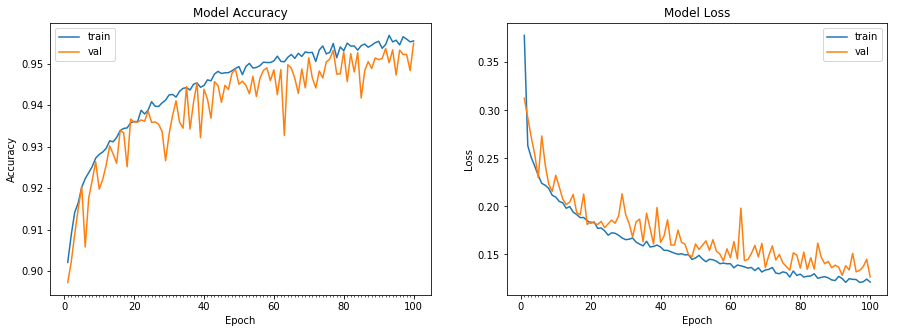

Accuracy on test data is: 76.11


In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, mode='min',min_lr=0.003)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
datagen = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False)

start = time.time()
batch_size = 128
model_info = model.fit_generator(datagen.flow(train_features, train_labels),
                                 steps_per_epoch = train_features.shape[0]/batch_size, epochs = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks=[reduce_lr,checkpoint])
end = time.time()

print ("Model took %0.2f seconds to train" %(end - start))


# plot model history
plot_model_history(model_info)


# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))



